## 1. Setup & Imports

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.abspath('../'))

# Our modules
from src.dataset.loaders import get_dataloaders
from src.detection.grounding_dino import (
    GroundingDINODetector,
    detect_symptoms,
    visualize_detections,
    compute_symptom_severity
)

# Configuration
SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 1  # Process one image at a time for visualization
NUM_CLASSES = 3  # Healthy, Rust, Frogeye

# Get directories
NOTEBOOK_DIR = Path(os.getcwd()) / 'notebooks'
RESULTS_DIR = NOTEBOOK_DIR / 'results'
DATA_DIR = Path(os.getcwd()) / 'data'

# Create results subdirectory
(RESULTS_DIR / 'grounding_dino').mkdir(exist_ok=True)

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Seed: {SEED}")
print(f"Results directory: {RESULTS_DIR / 'grounding_dino'}")
print(f"Data directory: {DATA_DIR}")

Device: mps
Seed: 21
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/grounding_dino
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data


## 2. Define Disease-Specific Text Prompts

These prompts describe the **visual symptoms** of each disease.
GroundingDINO will search for these patterns in the images.

In [2]:
# Disease-specific symptom descriptions
DISEASE_PROMPTS = {
    'Rust': [
        'red rust pustules on leaf',
        'brown rust spots',
        'orange pustules on soybean leaf'
    ],
    'Frogeye': [
        'circular lesions with dark borders',
        'round spots with dark rings',
        'eye-shaped lesions on leaf'
    ],
    'Healthy': [
        'green healthy leaf tissue',
        'unblemished leaf surface'
    ]
}

# Primary prompts (use first one for each disease)
PRIMARY_PROMPTS = {
    disease: prompts[0] 
    for disease, prompts in DISEASE_PROMPTS.items()
}

print("Disease-specific prompts:")
print("="*60)
for disease, prompt in PRIMARY_PROMPTS.items():
    print(f"{disease:12s}: '{prompt}'")

Disease-specific prompts:
Rust        : 'red rust pustules on leaf'
Frogeye     : 'circular lesions with dark borders'
Healthy     : 'green healthy leaf tissue'


## 3. Load GroundingDINO Model

In [3]:
# Initialize detector
detector = GroundingDINODetector(
    box_threshold=0.30,  # Lower threshold to catch more symptoms
    text_threshold=0.20,
    device=DEVICE
)

print("\n✓ GroundingDINO ready for symptom detection")

Loading GroundingDINO on mps...
final text_encoder_type: bert-base-uncased
✓ GroundingDINO loaded

✓ GroundingDINO ready for symptom detection


## 4. Load Test Dataset (MH)

In [4]:
# Load MH test set
print("\nLoading MH dataset...")
_, _, test_loader, dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Get class names
class_names = [class_name for class_name, _ in sorted(dataset.class_to_idx.items(), key=lambda x: x[1])]

print(f"✓ MH test set loaded")
print(f"  - Classes: {class_names}")
print(f"  - Total images: {len(test_loader.dataset)}")


Loading MH dataset...
Loaded 1225 samples for MH dataset.
Loaded 1225 samples for MH dataset.
✓ MH test set loaded
  - Classes: ['Healthy', 'Rust', 'Frogeye']
  - Total images: 185


## 5. Run Detection on Sample Images

Select representative images from each class and detect symptoms.

In [5]:
# Select 3 images per class for visualization
np.random.seed(SEED)

# Collect images by class
images_by_class = {i: [] for i in range(NUM_CLASSES)}

for img, label in test_loader:
    label_idx = label.item()
    if len(images_by_class[label_idx]) < 3:
        # Convert tensor to PIL Image
        img_np = img.squeeze().permute(1, 2, 0).numpy()
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(img_np)
        images_by_class[label_idx].append((pil_img, class_names[label_idx]))
    
    # Stop when we have enough samples
    if all(len(imgs) >= 3 for imgs in images_by_class.values()):
        break

print(f"✓ Collected {sum(len(imgs) for imgs in images_by_class.values())} sample images")

✓ Collected 9 sample images


## 6. Visualize Detections

For each image, run detection with all disease prompts and visualize.


Processing Healthy samples


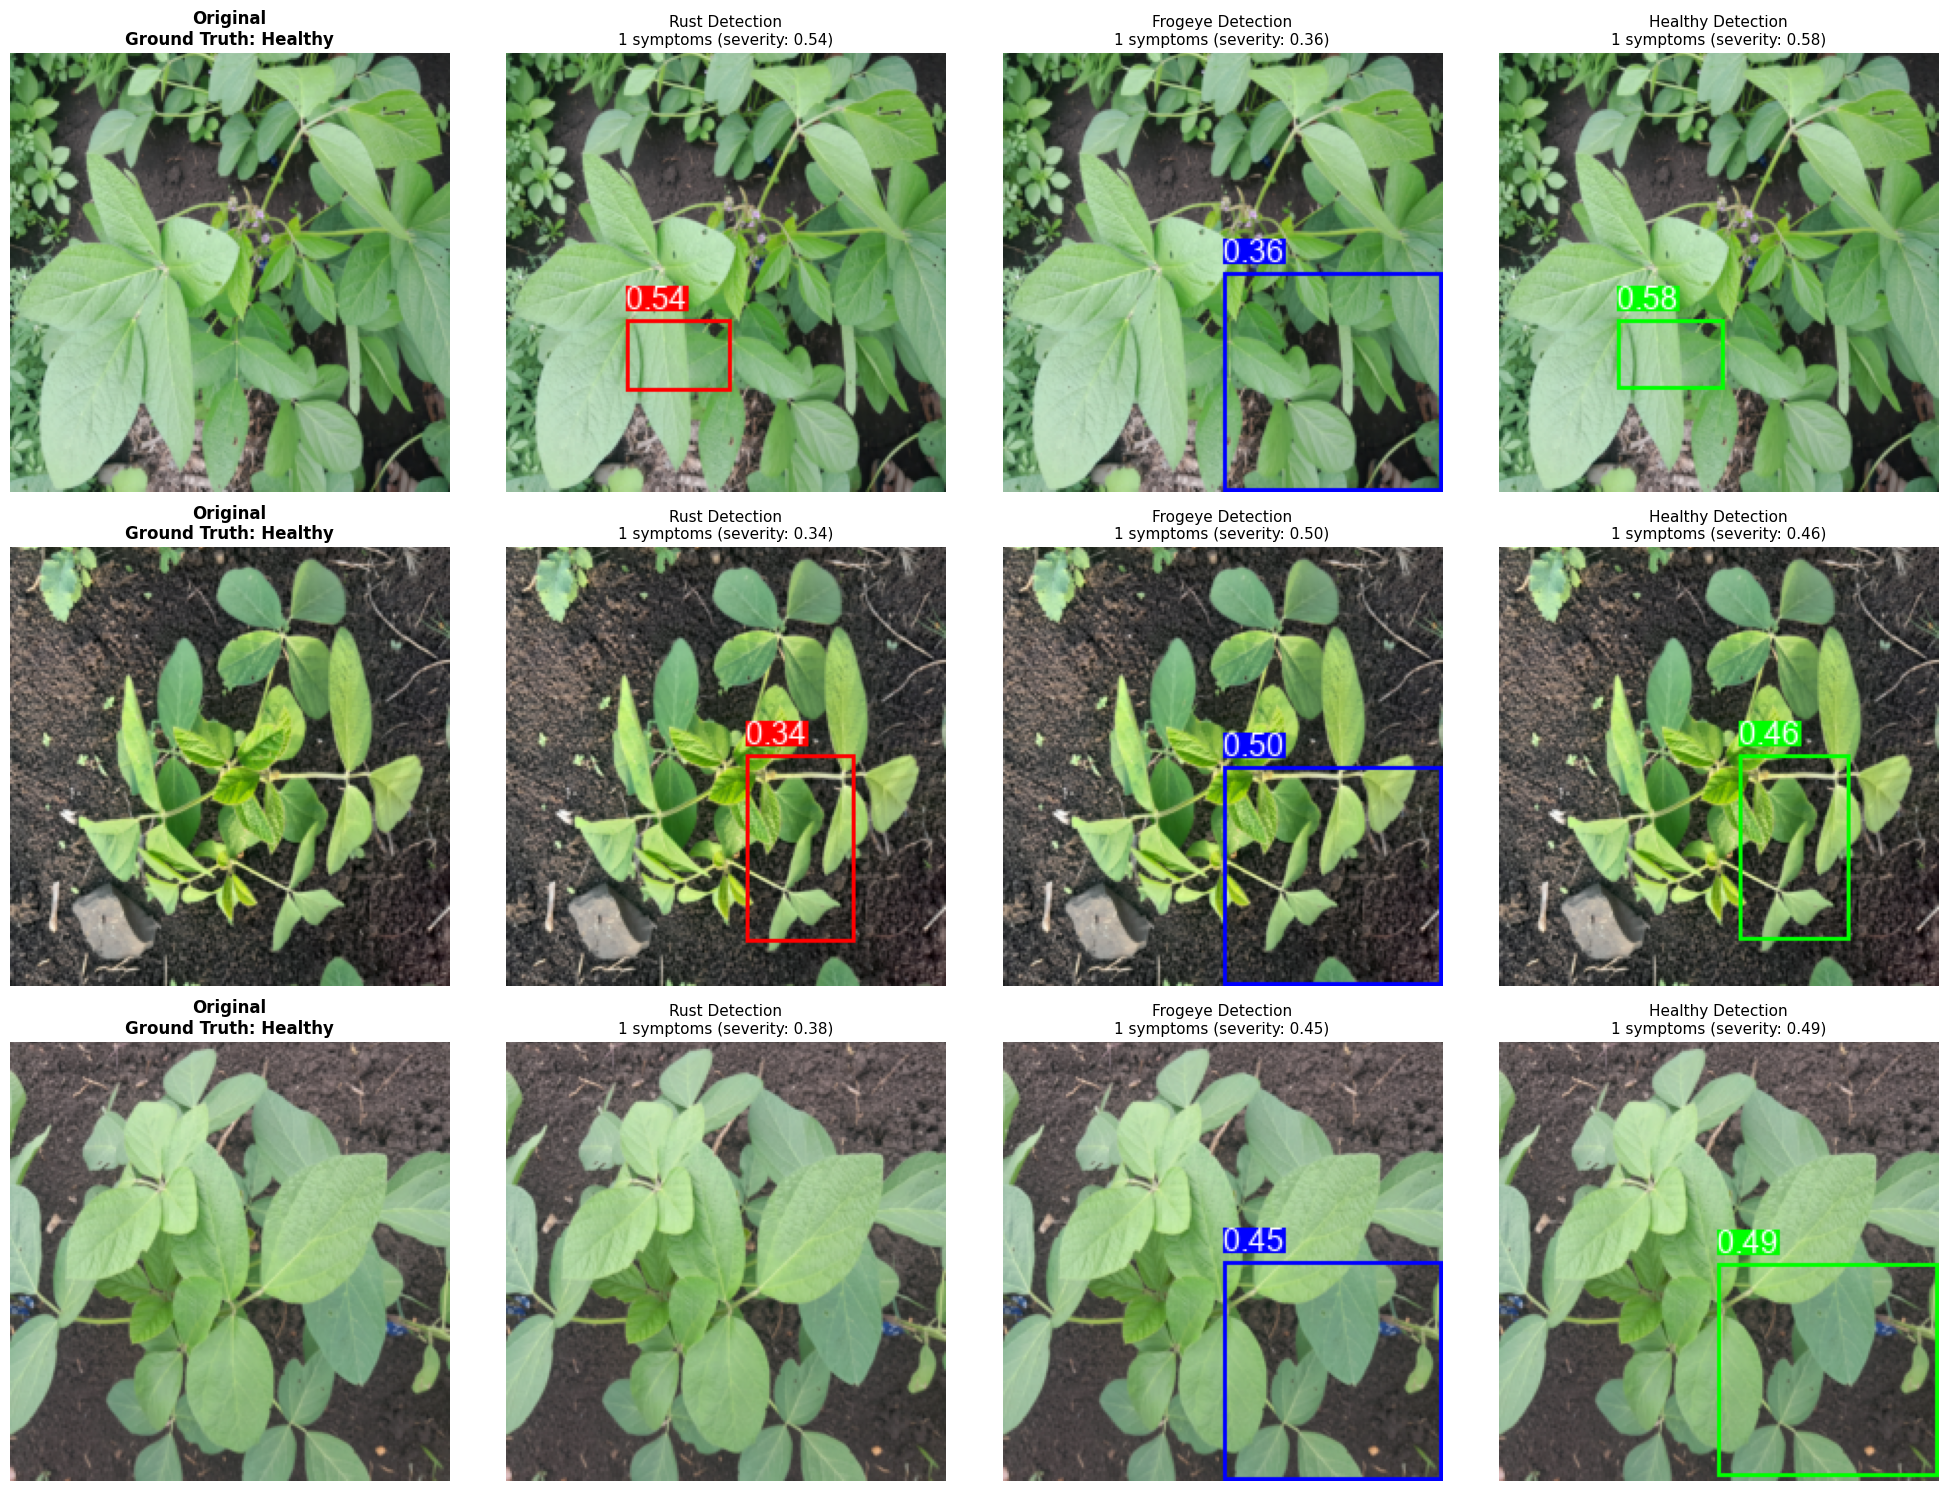

✓ Saved visualizations for Healthy

Processing Rust samples


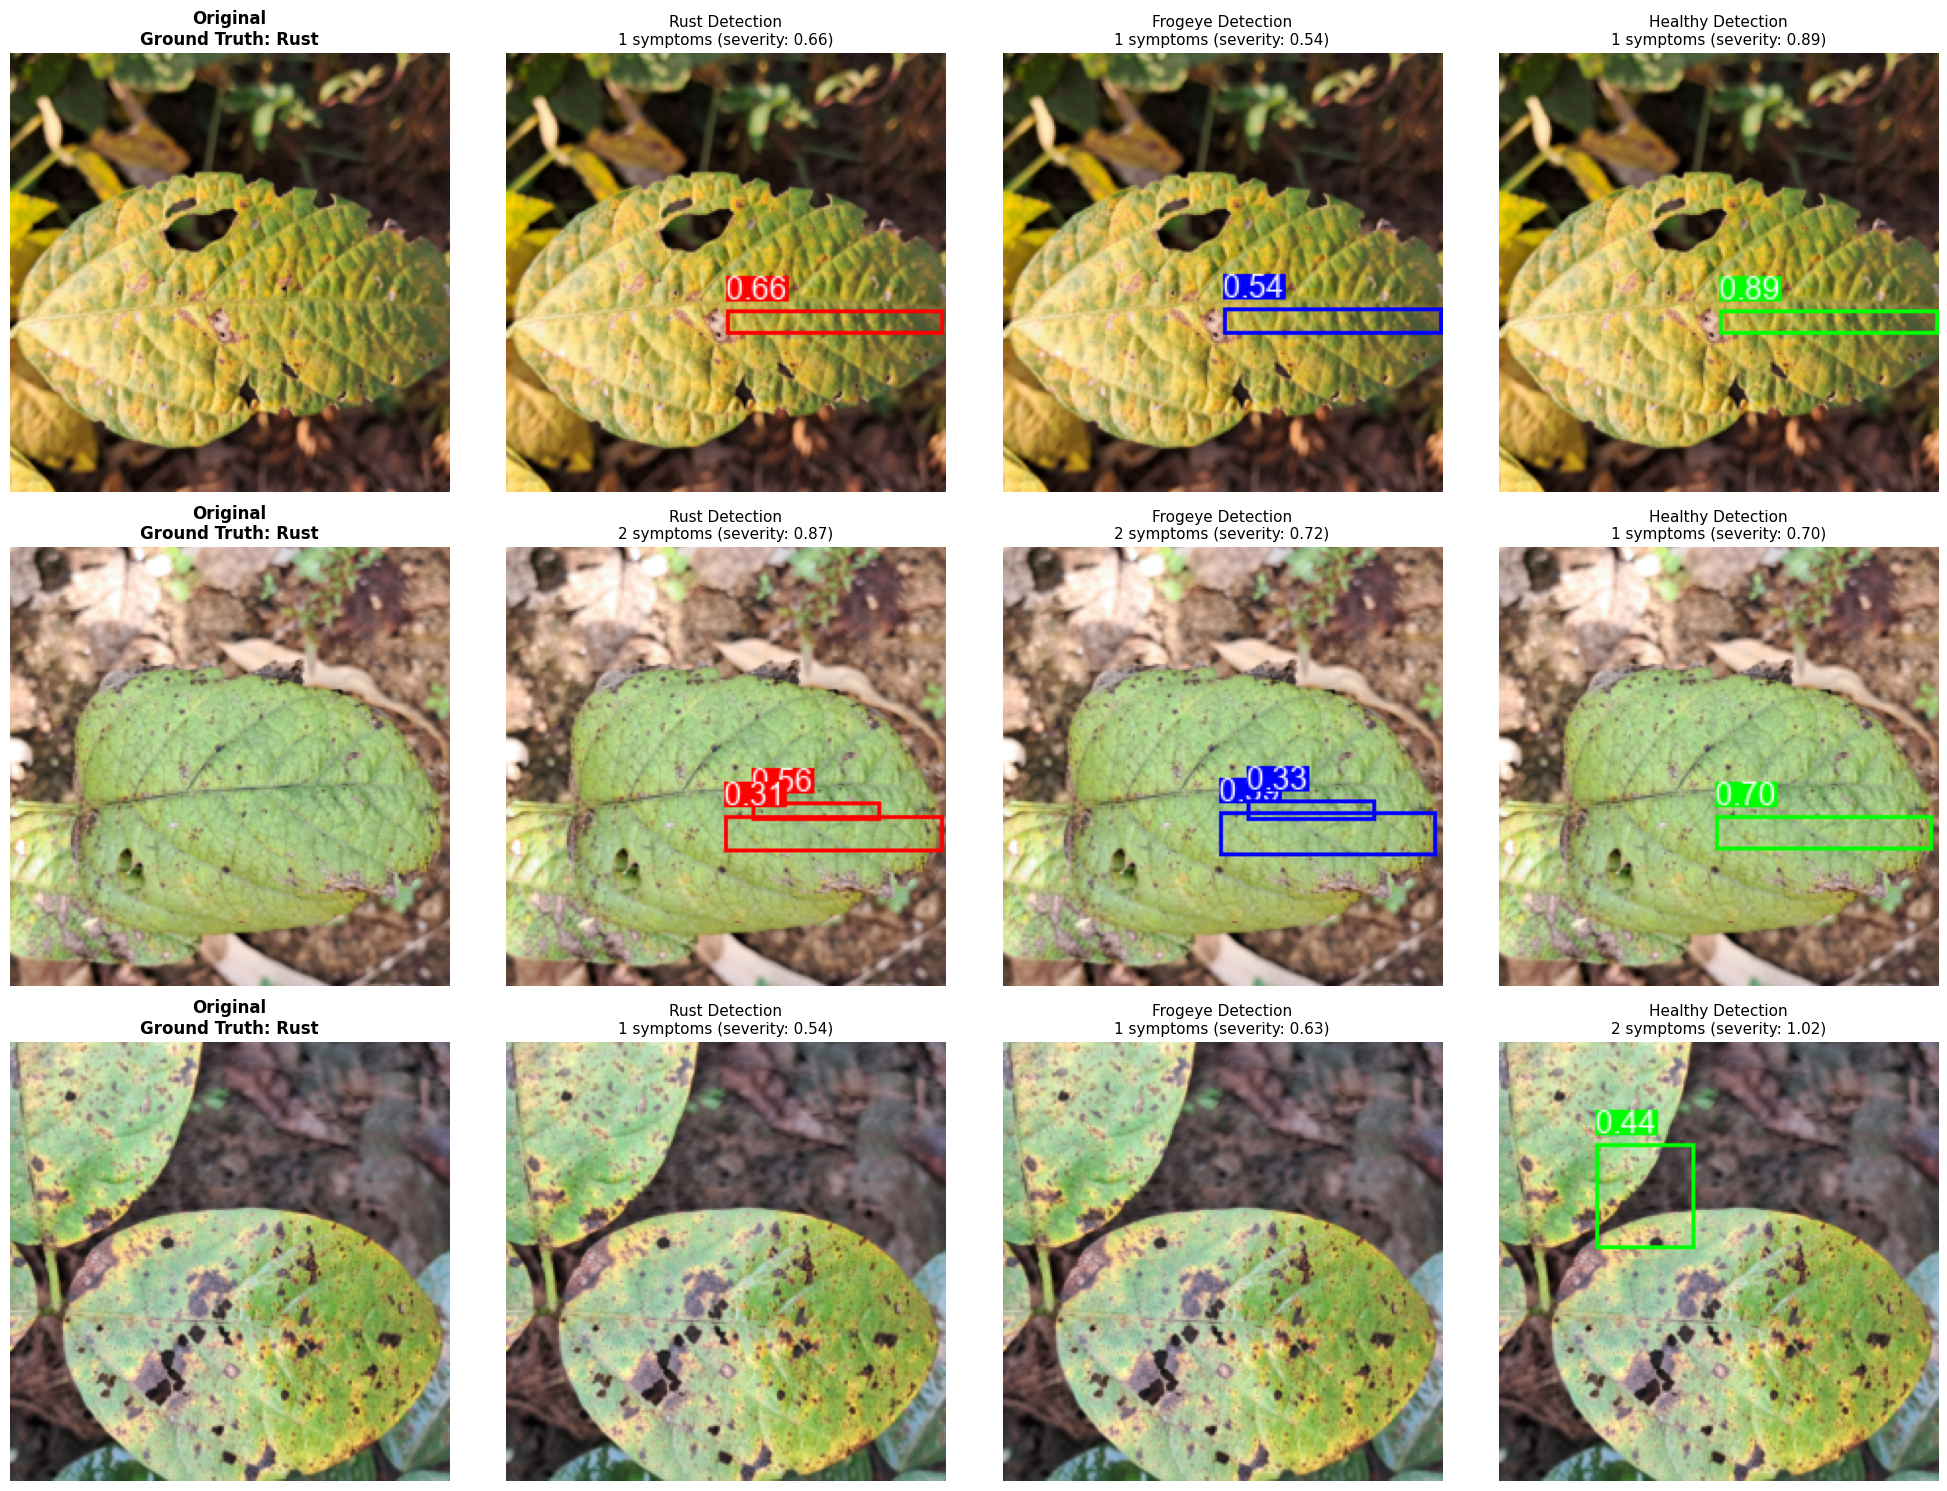

✓ Saved visualizations for Rust

Processing Frogeye samples


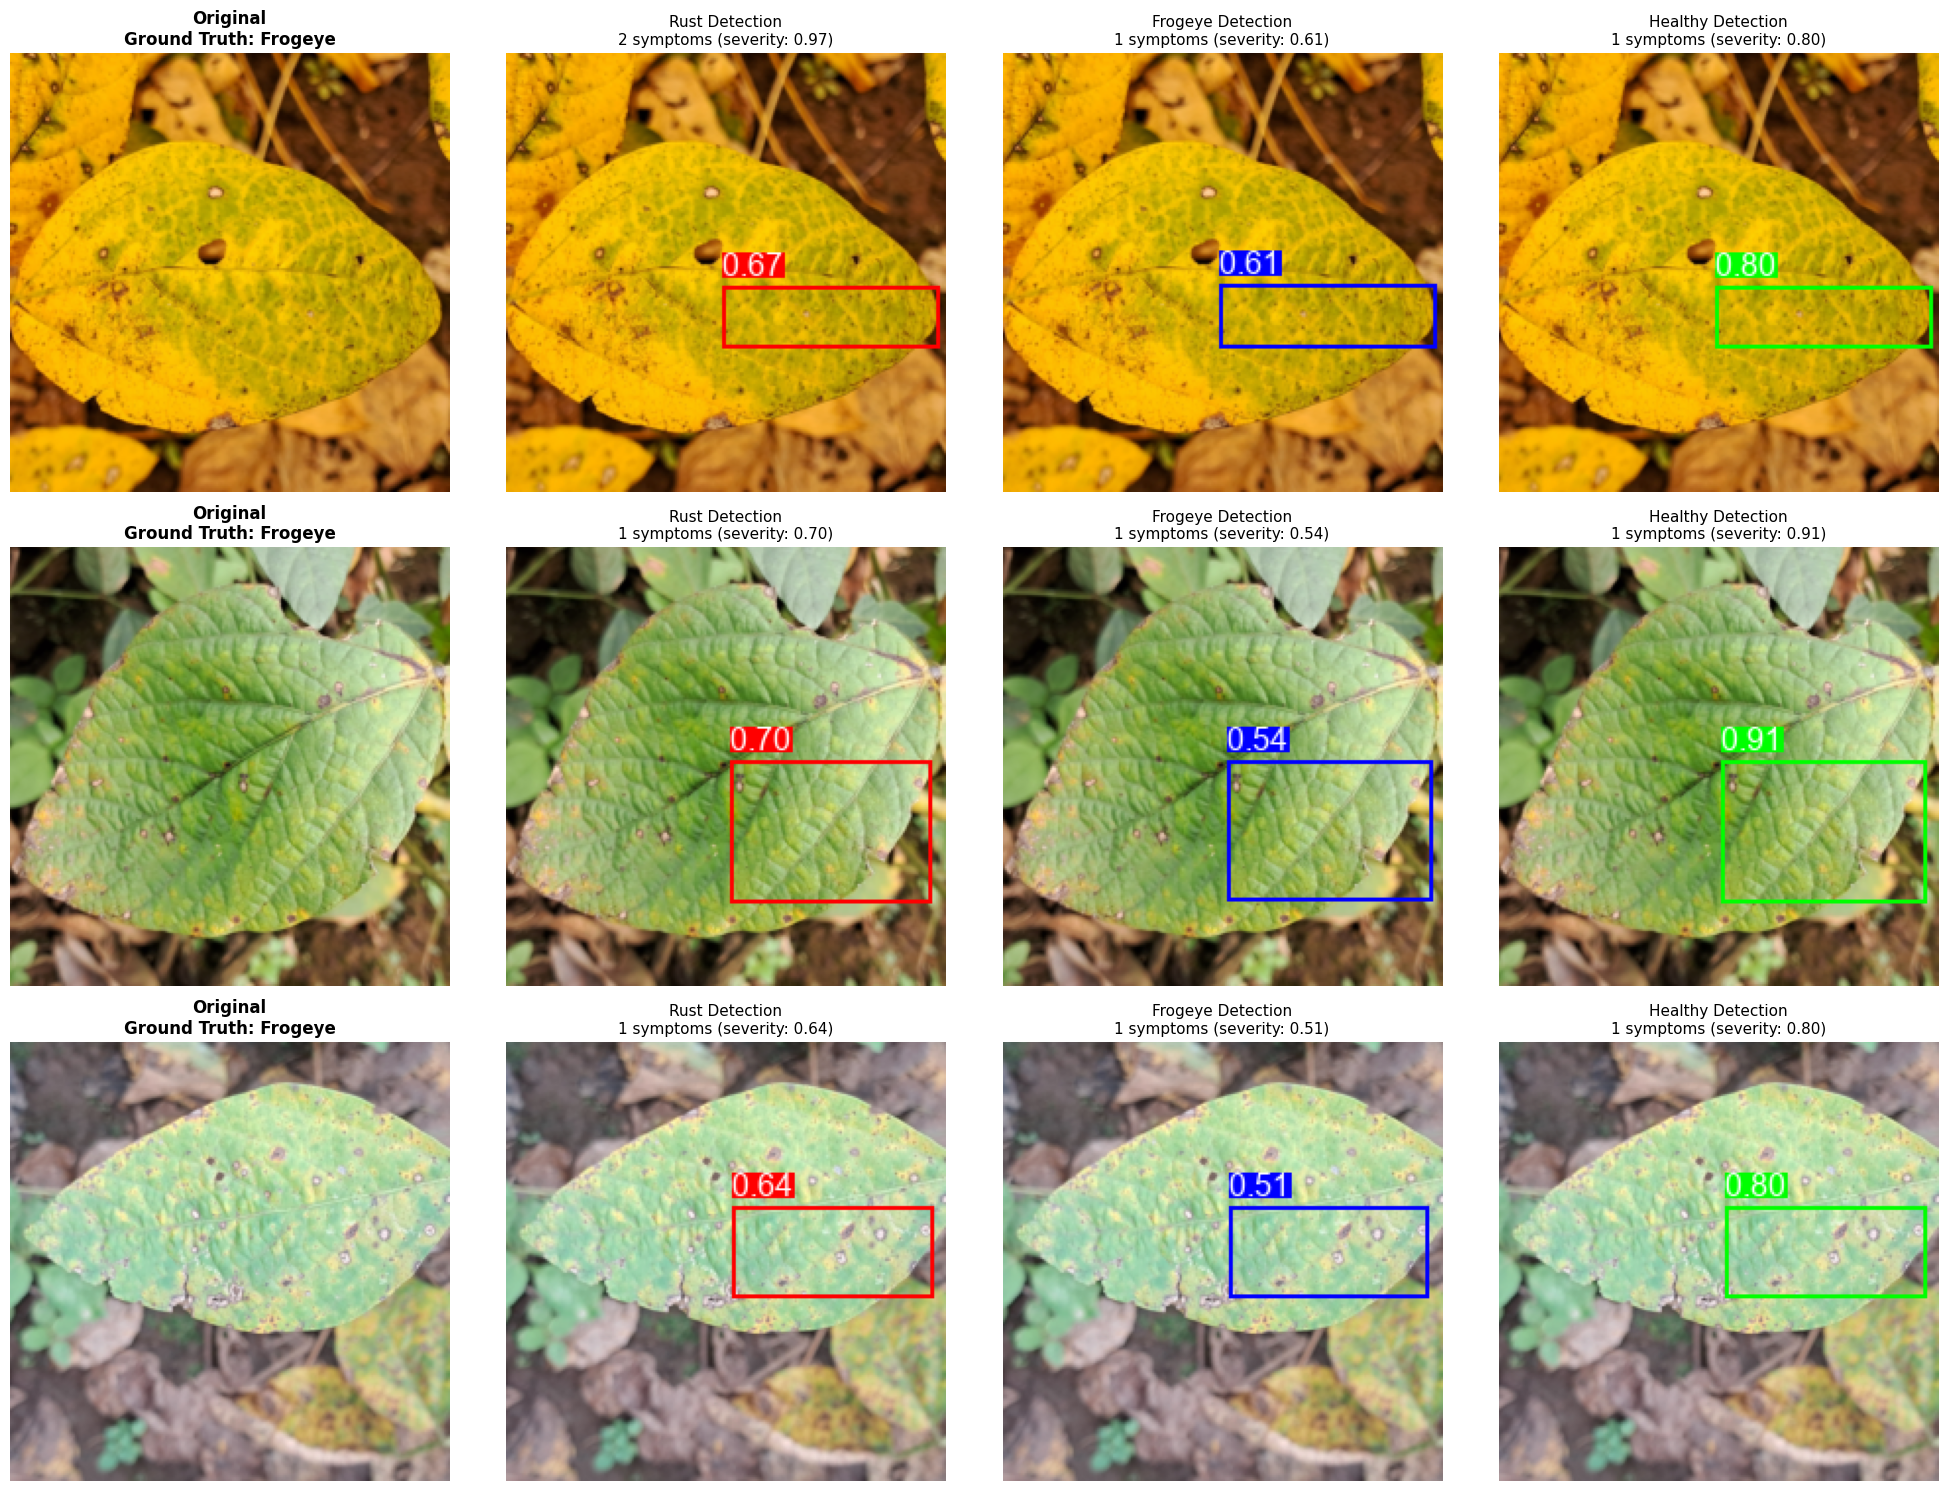

✓ Saved visualizations for Frogeye


In [6]:
# Visualize detections for each class
for class_idx, samples in images_by_class.items():
    class_name = class_names[class_idx]
    print(f"\n{'='*80}")
    print(f"Processing {class_name} samples")
    print(f"{'='*80}")
    
    fig, axes = plt.subplots(len(samples), 4, figsize=(20, 5*len(samples)))
    if len(samples) == 1:
        axes = axes.reshape(1, -1)
    
    for img_idx, (image, true_label) in enumerate(samples):
        # Detect symptoms for all diseases
        results = detect_symptoms(image, PRIMARY_PROMPTS, detector)
        
        # Original image
        axes[img_idx, 0].imshow(image)
        axes[img_idx, 0].set_title(f"Original\nGround Truth: {true_label}", fontsize=12, fontweight='bold')
        axes[img_idx, 0].axis('off')
        
        # Detection for each disease type
        colors = {'Rust': (255, 0, 0), 'Frogeye': (0, 0, 255), 'Healthy': (0, 255, 0)}
        
        for plot_col, (disease, (boxes, scores)) in enumerate(results.items(), start=1):
            if len(boxes) > 0:
                # Draw detections
                img_with_boxes = visualize_detections(
                    image, boxes, scores,
                    color=colors[disease],
                    thickness=2
                )
                axes[img_idx, plot_col].imshow(img_with_boxes)
                
                # Compute severity
                severity = compute_symptom_severity(boxes, scores, image.size, method='weighted_count')
                
                axes[img_idx, plot_col].set_title(
                    f"{disease} Detection\n{len(boxes)} symptoms (severity: {severity:.2f})",
                    fontsize=11
                )
            else:
                axes[img_idx, plot_col].imshow(image)
                axes[img_idx, plot_col].set_title(
                    f"{disease} Detection\nNo symptoms detected",
                    fontsize=11,
                    color='gray'
                )
            axes[img_idx, plot_col].axis('off')
    
    plt.tight_layout()
    plt.savefig(
        RESULTS_DIR / 'grounding_dino' / f'{class_name.lower()}_detections.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()
    
    print(f"✓ Saved visualizations for {class_name}")

## 7. Quantitative Analysis: Symptom Counts

Analyze detection statistics across all test images.

In [7]:
# Run detection on all test images
print("\nRunning detection on full test set...")

detection_results = []

for img, label in tqdm(test_loader, desc="Detecting symptoms"):
    # Convert to PIL
    img_np = img.squeeze().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(img_np)
    
    # Detect symptoms
    results = detect_symptoms(pil_img, PRIMARY_PROMPTS, detector)
    
    # Compute symptom counts and severities
    symptom_data = {
        'true_label': label.item(),
        'true_class': class_names[label.item()]
    }
    
    for disease, (boxes, scores) in results.items():
        symptom_data[f'{disease}_count'] = len(boxes)
        symptom_data[f'{disease}_severity'] = compute_symptom_severity(
            boxes, scores, pil_img.size, method='weighted_count'
        )
        symptom_data[f'{disease}_avg_confidence'] = scores.mean() if len(scores) > 0 else 0.0
    
    detection_results.append(symptom_data)

print(f"\n✓ Processed {len(detection_results)} images")


Running detection on full test set...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Detecting symptoms:   0%|          | 0/185 [00:00<?, ?it/s]


✓ Processed 185 images


## 8. Analysis: Symptom Patterns per Disease

In [ ]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(detection_results)

# Aggregate by true class
print("\n" + "="*80)
print("SYMPTOM DETECTION SUMMARY")
print("="*80)

for class_idx, class_name in enumerate(class_names):
    class_data = df[df['true_label'] == class_idx]
    
    print(f"\n{class_name} (n={len(class_data)}):")
    print("-" * 60)
    
    for disease in ['Rust', 'Frogeye', 'Healthy']:
        count_col = f'{disease}_count'
        severity_col = f'{disease}_severity'
        
        avg_count = class_data[count_col].mean()
        avg_severity = class_data[severity_col].mean()
        
        print(f"  {disease:10s}: {avg_count:6.2f} symptoms/image, severity={avg_severity:6.2f}")

# Save to CSV
df.to_csv(RESULTS_DIR / 'grounding_dino' / 'detection_results.csv', index=False)
print(f"\n✓ Results saved to {RESULTS_DIR / 'grounding_dino' / 'detection_results.csv'}")

## 9. Visualization: Symptom Count Distribution

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for disease_idx, disease in enumerate(['Rust', 'Frogeye', 'Healthy']):
    count_col = f'{disease}_count'
    
    # Plot distribution for each true class
    for class_idx, class_name in enumerate(class_names):
        class_data = df[df['true_label'] == class_idx][count_col]
        axes[disease_idx].hist(
            class_data,
            bins=20,
            alpha=0.5,
            label=class_name,
            edgecolor='black'
        )
    
    axes[disease_idx].set_xlabel('Number of Symptoms Detected', fontsize=12)
    axes[disease_idx].set_ylabel('Frequency', fontsize=12)
    axes[disease_idx].set_title(f'{disease} Symptom Counts', fontsize=14, fontweight='bold')
    axes[disease_idx].legend()
    axes[disease_idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'grounding_dino' / 'symptom_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution plot saved")

## 10. Classification Based on Symptom Counts

Can we classify diseases by counting detected symptoms?

In [ ]:
# Simple rule-based classifier
def classify_by_symptoms(rust_count, frogeye_count, healthy_count, rust_severity, frogeye_severity):
    """
    Classify based on symptom counts and severities.
    
    Logic:
    1. If both rust and frogeye low → Healthy
    2. If rust > frogeye (severity) → Rust
    3. If frogeye > rust (severity) → Frogeye
    """
    # Threshold for "disease present"
    if rust_severity < 1.0 and frogeye_severity < 1.0:
        return 0  # Healthy
    elif rust_severity > frogeye_severity:
        return 1  # Rust
    else:
        return 2  # Frogeye

# Apply classifier
df['predicted_label'] = df.apply(
    lambda row: classify_by_symptoms(
        row['Rust_count'],
        row['Frogeye_count'],
        row['Healthy_count'],
        row['Rust_severity'],
        row['Frogeye_severity']
    ),
    axis=1
)

# Compute accuracy
accuracy = (df['predicted_label'] == df['true_label']).mean()

print("\n" + "="*80)
print("SYMPTOM-BASED CLASSIFICATION RESULTS")
print("="*80)
print(f"\nAccuracy: {accuracy:.2%}")
print(f"\nNote: This is a simple rule-based classifier.")
print(f"A proper ML classifier trained on symptom features would perform better.")

## 11. Conclusion

### Key Findings

1. **Language-Guided Detection Works**: GroundingDINO successfully detects disease symptoms using natural language prompts without training

2. **Explainable Predictions**: Instead of black-box classification, we get:
   - "Found 15 rust pustules with 0.85 average confidence"
   - "Detected 3 frogeye lesions with 0.72 average confidence"

3. **Fine-Grained Attention**: Forces the model to focus on specific disease markers rather than generic leaf features

4. **Symptom Severity**: Detection counts provide interpretable severity metrics

### Advantages Over Classification

| Aspect | Standard CNN | GroundingDINO |
|--------|-------------|---------------|
| Explainability | ❌ Black box | ✅ Symptom counts |
| Fine-grained | ❌ Global features | ✅ Specific symptoms |
| Target annotations | ✅ Requires labels | ✅ Zero-shot |
| Domain shift | ❌ F1 drops 27% | ⚠️ To be evaluated |

### Next Steps

1. **Train Symptom Classifier**: Use detected symptom features to train ML classifier
2. **Multi-Prompt Ensemble**: Combine multiple prompt variations for robustness
3. **Prompt Engineering**: Optimize text descriptions for better detection
4. **Integration**: Combine with SAM for precise symptom segmentation